In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import scipy.io
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.utils.data
%matplotlib inline
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500"



/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dev/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:

df=pd.read_csv('/home/dev/Downloads/mpii_dataset.csv')



In [3]:
from sklearn.model_selection import train_test_split
df.drop(['Category','Activity'],1)
df = df.sample(n = len(df)).reset_index(drop=True)

/tmp/ipykernel_163723/934581437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Category','Activity'],1)


In [4]:
df.head()
from torch.utils.data import Dataset


In [5]:
transferdata_df = df.iloc[- 1400:, 0:]

test_df = pd.DataFrame()
test_df= test_df.append(transferdata_df)
train_df =df.drop(transferdata_df.index)
test_df = test_df.reset_index(drop=True)
train_df.head()

/tmp/ipykernel_163723/69786591.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df= test_df.append(transferdata_df)


,Unnamed: 0,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,049466828.jpg,993,1054,1001,839,1013,620,1058,585,...,378,1081,336,1131,469,1279,443,4.982587,laundry worker,occupation
1,0,002093412.jpg,842,799,871,703,928,576,863,571,...,428,842,435,777,396,739,341,2.736421,rock climbing,sports
2,0,036564216.jpg,1254,795,1208,674,1288,585,1343,583,...,477,1295,448,1374,472,1423,518,2.983828,fencing,sports
3,0,060785415.jpg,284,323,276,265,313,221,296,228,...,120,263,140,244,196,229,186,1.853602,"shoveling snow, by hand",lawn and garden
4,0,096602146.jpg,596,461,513,384,493,262,488,272,...,108,480,139,506,213,533,322,2.597439,"wheelbarrow, pushing garden cart or wheelbarrow",lawn and garden


In [6]:
img_loc=("/home/dev/Downloads/Images/images/")
#imgArray = np.array([])
#files = glob.glob(img_loc+'*.jpg')
imgcomb=[]
from numpy import copy
from sklearn.decomposition import PCA
from PIL import Image
images=[]       
trainimglabels=train_df.loc[:,'r ankle_X':'Scale']
trainfilenames=train_df['NAME']

testimglabels=test_df.loc[:,'r ankle_X':'Scale']
testfilenames=test_df['NAME']

#anyad=train_df.loc[:,'head top_X':'head top_Y']
#anyad2=train_df.loc[:,'head top_X':'head top_Y']

class Imagedataset(Dataset):
    def __init__(self,fnames,labels,transform=None):
        self.fnames=fnames
        self.labels=labels
        self.transform=transform
        self.CombArray=np.empty((0,16,2))
        self.BackupLabels=labels.copy()

    def __len__(self):
        return len(self.fnames)
    
    def NormaliseData(self,img,idx):
        #print(self.labels.head())
        height, width= img.shape
        #print(self.labels.head())
        Xcoord=[]
        Ycoord=[]
        x=0
       
        for i in range(0,32,2):
            self.labels.iloc[idx,i]=(self.labels.iloc[idx,i]*(256/width))
            Xcoord.append(self.labels.iloc[idx,i])
            self.labels.iloc[idx,i+1]=(self.labels.iloc[idx,i+1]*(256/height))
            Ycoord.append(self.labels.iloc[idx,i+1])
            x=x+1
        
        X_min=np.min(Xcoord)
        Y_min=np.min(Ycoord)
        X_max=np.max(Xcoord)
        Y_max=np.max(Ycoord)

        
    
        #self.CombArray = np.concatenate((self.CombArray, np.stack((Xcoord, Ycoord), axis=1)[np.newaxis, :, :]), axis=0)
        """
        x=0
        for i in range(0,31,2):
            self.labels.iloc[idx, i] = (self.labels.iloc[idx, i] - X_min) / (X_max - X_min)
            self.labels.iloc[idx, i+1] = (self.labels.iloc[idx, i+1] - Y_min) / (Y_max - Y_min)
            x=x+1
        #print(self.labels.head())"""
        normImg=cv2.resize(img,(256,256))
        self.labels.astype(np.float32)
        return normImg
            
    def __getitem__ (self, idx):
        Rimg=cv2.imread(img_loc+self.fnames[idx])
        Gimg=cv2.cvtColor(Rimg,cv2.COLOR_BGR2GRAY)
        Gimg=self.NormaliseData(Gimg,idx)
        
        
        
        """
        #PCA whitening, edge detection etc, nothing worked in helping the model learn.
        for i in range(0,2,2):
            y=self.labels.iloc[idx,i+1]
            x=self.labels.iloc[idx,i]
            cv2.circle(Gimg,(int(x),int(y)),5,(0,255,0),-1)
        cv2.imshow("gay", Gimg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        """
        Gimg=Gimg.reshape(-1,Gimg.shape[-1])

        pca=PCA(n_components=None, whiten=True)
        pca.fit(Gimg)
        Timg=pca.transform(Gimg)
        Timg=Timg.reshape(-1,Gimg.shape[-1])
        img_shape=(256,256)
       
        Gimg = Gimg.reshape(img_shape[0], img_shape[1])
        Timg = Timg.reshape(img_shape[0], img_shape[1])
        Gimg = cv2.convertScaleAbs(Gimg)
        #Timg=pca.inverse_transform(Timg.reshape(1,-1)).reshape([256,256])
        #img_merged = cv2.merge([Timg[:, :, 0], Timg[:, :, 0], Timg[:, :, 2]])
       
        
        #img_merged=cv2.cvtColor(img_merged,cv2.COLOR_BGR2GRAY)
       

        #print(Timg.shape)
        """
        cv2.imshow("Original Image", edges)
       # cv2.imshow("Whitened Image", Timg)
        #cv2.imshow("Edge", Timg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        """
        Gimg = Gimg.astype(np.float32) / 255.
        if self.transform:
            Gimg = self.transform(Gimg)
       
        helper=self.labels.iloc[idx, :-1]
       
        target=helper.values
        #target=target.reshape(-1,2)
        target.astype(np.float32)
      
        return (Gimg,target)

    def GetOgLabel(self):
        return (self.CombArray)
        
    def cleanup(self):
        del(self.CombArray)
        del(self.labels)
        #print(self.labels.shape)
        #self.labels=np.empty((15972, 33))
        self.labels=self.BackupLabels.copy()
        self.CombArray=np.empty((0,1,2))
    
train_dataset= Imagedataset(trainfilenames,trainimglabels)
test_dataset= Imagedataset(testfilenames,testimglabels)

train_loader=DataLoader(train_dataset,batch_size=5, shuffle=False, num_workers=12)
test_loader=DataLoader(test_dataset,batch_size=5, shuffle=True)

#anyad.head()


In [7]:
data, target= train_dataset.__getitem__(0)
#asdf=pd.DataFrame(data)
#a=train_dataset.GetOgLabel()


In [8]:

train_dataset.cleanup()

In [9]:

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [10]:
#train_dataset.fnames.iloc[4]
import itertools

In [11]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,stride=1,padding=1)
        self.conv7 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=5,stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=5,stride=1,padding=1)
       
   
        self.fc1 = nn.Linear(64*61*61,64)
        self.fc2 = nn.Linear(64,32)


        self.fc3 = nn.Linear(64,2)
        
        

    def forward(self, X):
        X = self.conv1(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        X = self.conv3(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
       
       
    
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X = F.leaky_relu(X)
        X = self.fc2(X)
        """
        X = F.leaky_relu(X)
        X = self.fc3(X)
        """
        
        

        X=X.view(-1,32,1)
        output =X
        return output
    
torch.manual_seed(101)
model = ConvolutionalNetwork().to(dev)
print(dev)

cuda:0


In [12]:
#print(anyad.size)

In [13]:
"""
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
        
    def forward(self, y_pred, y_true):
        error = y_pred - y_true
        abs_error = torch.abs(error)
        quadratic = torch.min(abs_error, torch.tensor(self.delta))
        linear = (abs_error - quadratic)
        loss = 0.5 * quadratic ** 2 + self.delta * linear
        return torch.mean(loss)
        """

'\nclass HuberLoss(nn.Module):\n    def __init__(self, delta=1.0):\n        super(HuberLoss, self).__init__()\n        self.delta = delta\n        \n    def forward(self, y_pred, y_true):\n        error = y_pred - y_true\n        abs_error = torch.abs(error)\n        quadratic = torch.min(abs_error, torch.tensor(self.delta))\n        linear = (abs_error - quadratic)\n        loss = 0.5 * quadratic ** 2 + self.delta * linear\n        return torch.mean(loss)\n        '

In [14]:

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [15]:
def train(model, dev, train_loader, optimizer):
  
  model.train()
  EPOCHS = 50
  batch_size = 15
  id=0
  #for batch_idx in range(0,len(train_loader),batch_size):
  for epoch in range(EPOCHS):
    id=0
    print("Performing Cleanup")
    print("Loading Epoch...")
    train_dataset.cleanup()  
    for data, target in train_loader:
        
      data=data.unsqueeze(1)
      target=target.unsqueeze(2)
      #print("dik")
      #start_idx = batch_idx
      #end_idx = min(len(train_loader), batch_idx + 20)
    # batch=list(itertools.islice(train_loader,batch_size))
      ###for data, target in batch:
        #print("coc")
      #print(target.shape, data.shape)
      data, target = data.to(dev), target.to(dev)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output.float(), target.float())
      loss.backward()
      optimizer.step()
      
      
     # if(id%15==0):
      print(f'Train Epoch: {epoch} [{id}/{len(train_loader)} ({100.*id/len(train_loader):.0f}%)]\tLoss: {loss.item():.3f}')

      if(id*len(data)==300):
        break   
      id=id+1
    
        

In [16]:

#train_dataset.__getitem__(0)
#test_dataset.__getitem__(2)


In [17]:
torch.cuda.empty_cache()

In [18]:

 train(model, dev, train_loader, optimizer)

Performing Cleanup
Loading Epoch...
Train Epoch: 0 [0/3195 (0%)]	Loss: 120.544
Train Epoch: 0 [1/3195 (0%)]	Loss: 115.072
Train Epoch: 0 [2/3195 (0%)]	Loss: 134.227
Train Epoch: 0 [3/3195 (0%)]	Loss: 128.594
Train Epoch: 0 [4/3195 (0%)]	Loss: 107.679
Train Epoch: 0 [5/3195 (0%)]	Loss: 134.258
Train Epoch: 0 [6/3195 (0%)]	Loss: 95.863
Train Epoch: 0 [7/3195 (0%)]	Loss: 142.546
Train Epoch: 0 [8/3195 (0%)]	Loss: 116.178
Train Epoch: 0 [9/3195 (0%)]	Loss: 75.413
Train Epoch: 0 [10/3195 (0%)]	Loss: 106.834
Train Epoch: 0 [11/3195 (0%)]	Loss: 93.381
Train Epoch: 0 [12/3195 (0%)]	Loss: 122.973
Train Epoch: 0 [13/3195 (0%)]	Loss: 99.832
Train Epoch: 0 [14/3195 (0%)]	Loss: 120.357
Train Epoch: 0 [15/3195 (0%)]	Loss: 101.824
Train Epoch: 0 [16/3195 (1%)]	Loss: 101.924
Train Epoch: 0 [17/3195 (1%)]	Loss: 114.542
Train Epoch: 0 [18/3195 (1%)]	Loss: 96.304
Train Epoch: 0 [19/3195 (1%)]	Loss: 89.407
Train Epoch: 0 [20/3195 (1%)]	Loss: 75.743
Train Epoch: 0 [21/3195 (1%)]	Loss: 78.019
Train Epoch: 0

In [19]:
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    device = next(model.parameters()).device
    
    mpjpe = 0.0
    num_samples = 0
    mse = 0.0
    rmse = 0.0
    ssr = 0.0
    sst = 0.0
    with torch.no_grad():
        train_dataset.cleanup()
        test_dataset.cleanup()
        for data, target in data_loader:
            #print("wtf")
            target=target.unsqueeze(2)
            data=data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
        #MPJPE
            batch_mpjpe = torch.sqrt(torch.sum((output - target)**2, dim=-1)).mean()
            mpjpe += batch_mpjpe.item() * data.size(0)
            num_samples += data.size(0)
        #MSE
       
            batch_mse = loss.item() * data.size(0)
            mse += batch_mse
        
        #RMSE 
            batch_rmse = torch.sqrt(loss).item() * data.size(0)
            rmse += batch_rmse
        
        #SSR and SST 
            batch_ssr = torch.sum((output - target)**2).item()
            batch_sst = torch.sum((target - torch.mean(target))**2).item()
            ssr += batch_ssr
            sst += batch_sst
        
            num_samples += data.size(0)
    
    num_samples_total = num_samples * data_loader.batch_size   
    r2 = 1.0 - (ssr / sst)
    
    mse /= num_samples
    rmse /= num_samples
 
    avg_mpjpe = mpjpe / num_samples_total

    
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 score: {r2:.4f}, MPJPE: {mpjpe:.4f}')
            
   


In [20]:
 evaluate(model, test_loader)


MSE: 1767.3808, RMSE: 29.3506, R2 score: -0.0833, MPJPE: 64902.8770


In [27]:
def predict_image(model, test_loader, device):
   
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        predictions_denorm=[]
        train_dataset.cleanup()
        test_dataset.cleanup()
        for i, (data, target) in enumerate(test_loader):
            if i== 1:
                break
            data=data.unsqueeze(1)
            target=target.unsqueeze(2)
            data=data.to(dev)
            predictions = model(data)

            predictions = predictions.cpu().numpy()
            #print(predictions.shape)
            target = target.cpu().numpy()
            
            """ 
            ogX=[]
            ogY=[]
            OgValues=test_dataset.GetOgLabel()
            for i in range(predictions.shape[0]):
                for k in range(0,OgValues.shape[1],2):
                    ogX.append(OgValues[i,k])
                    ogY.append(OgValues[i,k+1])
                X_min=np.min(ogX)
                Y_min=np.min(ogY)
                X_max=np.max(ogX)
                Y_max=np.max(ogY)
                for j in range(0,predictions.shape[1],2):
                    
                    predictions[i,j] = predictions[i, j] * (X_max-X_min)+X_min 
                    predictions[i,j+1] = predictions[i, j+1] * (Y_max-Y_min)+Y_min  
                    print(predictions[i,j])
                    print(predictions[i,j+1])
            """
            test_dataset.cleanup()
            
            #print("wft")
            # Plot the images with predicted keypoints
            for i in range(0,len(data)):
                

                img_data = np.transpose(data[i].cpu().numpy(), (1, 2, 0))
                plt.imshow(img_data)
                plt.scatter(predictions[i][::2], predictions[i][1::2] , s=50)
                #print(predictions[i][::2],"\t\t", predictions[i][1::2])
                plt.show()


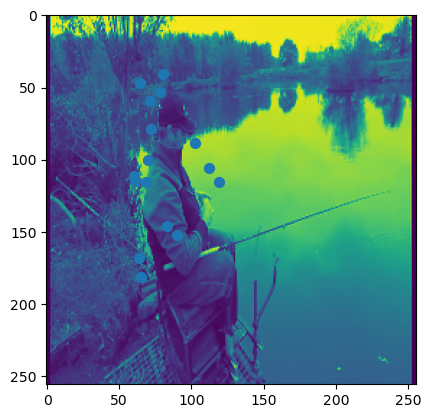

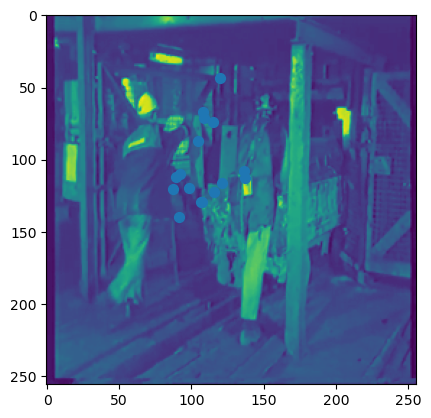

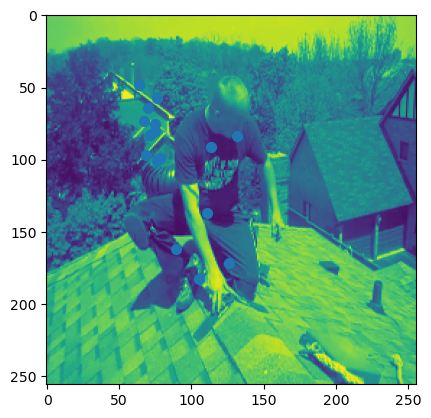

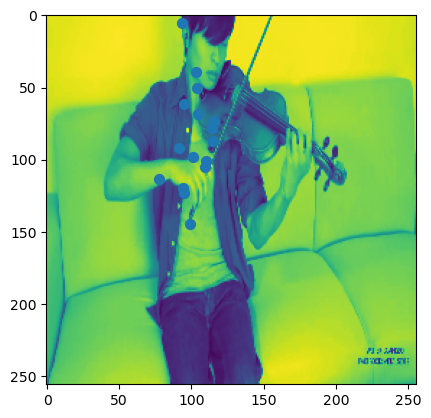

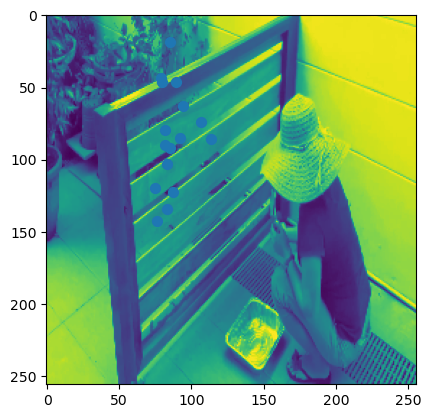

In [28]:
predict_image(model, test_loader, dev)